<a href="https://colab.research.google.com/github/ConradBitt/processamento_linguagem_natural/blob/master/Regress%C3%B5es_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib as mpl

from matplotlib import pyplot as plt


sns.set_context('talk')
sns.set_style('darkgrid')

vou passar alguns hiperparâmetros ao matplotlib

In [ ]:
mpl.rcParams['figure.figsize'] = (10,6)

# Contexto 

Vamos supor que temos uma empresa de planejamento e queremos fazer a previsão do número de passageiros nos anos seguintes de uma companhia aerea, os dados disponíveis são o seguintes:

In [ ]:
viagens = pd.read_csv('https://gist.githubusercontent.com/ConradBitt/9d5376781d4d4af6f3ba2186ab71e66e/raw/d715b05bf6a5a664d44773a5998948fa5b5fbdb8/passageiros.csv')
viagens.head()

,tempo,passageiros
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


Note que temos o ano seguido do mês. O mês esta sendo representado pelo decimal, $1949.0000$ é janeiro, $1949.083333$ é fevereiro, $1949.166667$ é março. Ou seja, estamos somando $0.083333$ a cada mês, isso porque $1 / 12 = 0.083333$

Sabendo então que éé uma série temporal podemos visualizar com o comando ``.plot()`` do pandas ou usando o seaborn:

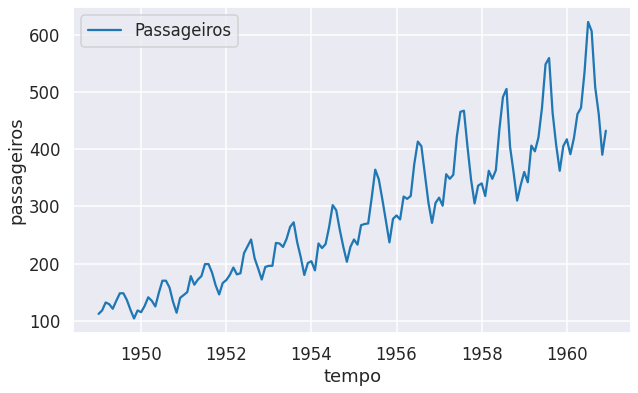

In [ ]:
ax = sns.lineplot(x = 'tempo', y='passageiros', data=viagens, label='Passageiros')

## Modelo

Uma rede neural pode ser expressa por uma função de $x$, por exemplo:

$$ y = f(x),$$ 

onde $y$ é o nosso target, $x$ o dado de entrada e $f$ o modelo que será utilizado. O modelo pode ser uma regressão logistica, um perceptron, multi layer perceptron dentre vários outros.

Lembrando que este modelo é pra uma única amostra, no nosso caso $x$ é um vetor $\vec{x}$, logo:

$$ \vec{y} = f(\vec{x}).$$

Em geral, os modelos funcionam melhor em dados normalizados, isto é que estejam entre a mesma escala. Por exemplo, nos dados de viagens o tempo é dado na escala de milhares 1948,1949,1950, etc, mas os targets estão na ordem de centenas 100, 150, 160 passageiros, ou seja, a ordem de grandezas dos dados são diferentes e para ter um desempenho melhor é recomendado uma normalização.

Para fazer esta normalização vamos utilizar uma normalização através do desvio padrão, a nova variável $z$ é:

$$z = \frac{x - \mu}{\sigma},$$ 

onde $\mu$ é a média amostra e $\sigma$ o desvio padrão amostral.

Este normalizador vem do módulo Sci kit Learn:

> https://sklearn.org/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()

In [ ]:
sc.fit(viagens)  # ajustando os dados ao normalizador

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
viagens_normalizadas = sc.transform(viagens)  # transformando os dados

In [ ]:
viagens_normalizadas = pd.DataFrame(viagens_normalizadas, columns=['tempo','passageiros'])


### Visualizando dados normalizados

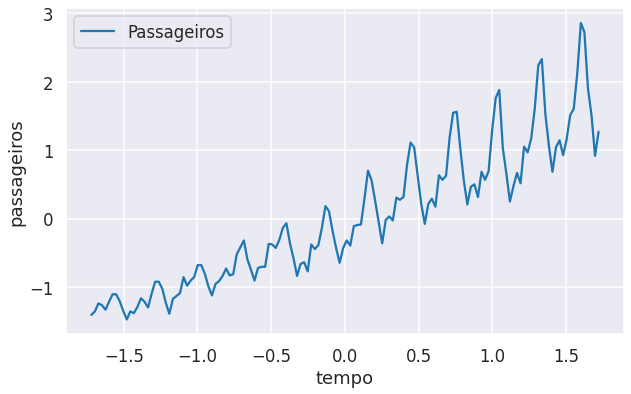

In [ ]:
ax = sns.lineplot(x = 'tempo', y='passageiros', data=viagens_normalizadas, label='Passageiros')
ax;

Note que os valores mudaram.

## Separando dados de Treino e Teste

A ideia é separar em dados de treino e teste, justamente pra treinar e depois testar com o objetivo de avaliar a qualidade de previsão do modelo.



In [ ]:
tamanho_treino = int(len(viagens_normalizadas) * 0.9)
tamanho_teste = int(len(viagens_normalizadas)) - tamanho_treino

print(f'Tamanho dados de treino: {tamanho_treino}\nTamanho dados de treino: {tamanho_teste}')

Tamanho dados de treino: 129
Tamanho dados de treino: 15


In [ ]:
x_treino = viagens_normalizadas['tempo'].iloc[:tamanho_treino]
y_treino = viagens_normalizadas['passageiros'].iloc[:tamanho_treino]

x_teste = viagens_normalizadas['tempo'].iloc[-tamanho_teste:]
y_teste = viagens_normalizadas['passageiros'].iloc[-tamanho_teste:]

Note agora podemos analisar os dados de treino e teste:

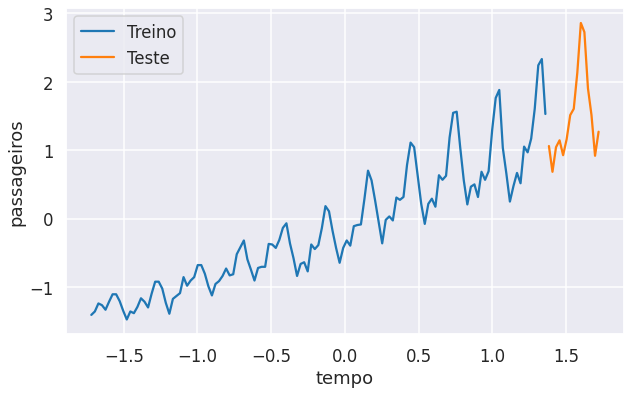

In [ ]:
ax = sns.lineplot(x = x_treino, y = y_treino, label='Treino')
ax = sns.lineplot(x = x_teste, y = y_teste, label='Teste')
ax;

Como já foi dito anteriormente um modelo precisa de uma entrada e uma saida, para criar esta estrutura com o [keras](https://keras.io/api/) precisamos de um objeto do tipo [``sequencial``](https://keras.io/guides/sequential_model/). Além dessa estrutura precisamos dizer qual a forma organizacional das conexões da rede, no caso será [dense](https://keras.io/api/layers/core_layers/dense/):

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
regressor = Sequential()

Com o modelo sequencial instanciado devemos adicionar as estruturas da rede, no caso usando a função ``modelo.add()``.

primeiro passamos a dimensionalidade ``units`` para a camada Dense, depois quais são os pesos ou ``kernel_initializer`` e depois um viés ``use_bias``, isso faz com que o modelo de previsão $y'$ será dado por:  

$$y' = Wz + b,$$

onde $y'$ é o número normalizado de passageitos previsto, $W$ o kernel que éé basicamente os pesos e $b$ o viés. Além disso outra forma de melhorar este modelo é aplicar uma função de ativação $a(z) = Cz$, onde a estruturas dos neurônios da rede serão: 

$$y' = a(Wz + b),$$

por padrão vamos usar uma função de ativação linear, no caso $a(z) = 1z$.

O código é o seguinte:

In [ ]:
regressor.add(
    Dense(1, input_dim=1,
          kernel_initializer='Ones',
          use_bias=False,activation='linear'
          )
    )

Agora temos a estrutura da rede montada, ou seja, uma rede densa com ativaçãão linear, pesos iguais a 1 e com um viés. Seguindo em frente precisamos definir uma função de perda, ou seja, é basicamente medir o erro entre $y$ (dados de teste) e $y'$ (dados previsto pelo modelo).

In [ ]:
regressor.compile(
  loss='mean_squared_error',
    optimizer='adam'
    )

O parâmetro ``optimizer`` indica qual tipo de otimização será feita para minimizar o erro. Por exemplo, a cada foward se tem um erro medido pelo $MSE$ o otimizador vai então fazer alterações no vies e no kernel no backward para tentar diminuir o erro. Existem vários otimizadores, os mais conhecidos são o ``adam`` e o ``SGD``, ambos otimizadores baseados em gradiente descendente estocastico.

> [ADAM: A METHOD  FOR STOCHASTIC OPTIMIZATION](https://arxiv.org/pdf/1412.6980.pdf)

Podemos ver quais são as caracteristicas da rede, com o méétodo ``.summary()``:

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


## Ajustando o modelo

Agora podemos ajustar o modelo aos dados de treino e tentar realizar o forward:

In [ ]:
regressor.fit(x = x_treino, y = y_treino)

5/5 [==============================] - 0s 2ms/step - loss: 0.1384


note o modelo foi ajustado e treinou 5 vezes. Note que a ``loss`` neste caso nunca será zero porque estamos tentando ajustar uma série temporal com sasonalidade com uma reta. 

Vamos comparar o dado predito através dos dados de teste:

In [ ]:
y_predito = regressor.predict(x_teste)

In [ ]:
y_predito[:,0]

array([1.3773638, 1.4013181, 1.4252722, 1.4492263, 1.4731805, 1.4971346,
       1.5210888, 1.5450429, 1.568997 , 1.5929513, 1.6169053, 1.6408596,
       1.6648136, 1.6887679, 1.7127221], dtype=float32)

In [ ]:
y_predito = pd.Series(y_predito[:,0], index=y_teste.index)
y_predito

129    1.377364
130    1.401318
131    1.425272
132    1.449226
133    1.473181
134    1.497135
135    1.521089
136    1.545043
137    1.568997
138    1.592951
139    1.616905
140    1.640860
141    1.664814
142    1.688768
143    1.712722
dtype: float32

exibindo os dados:

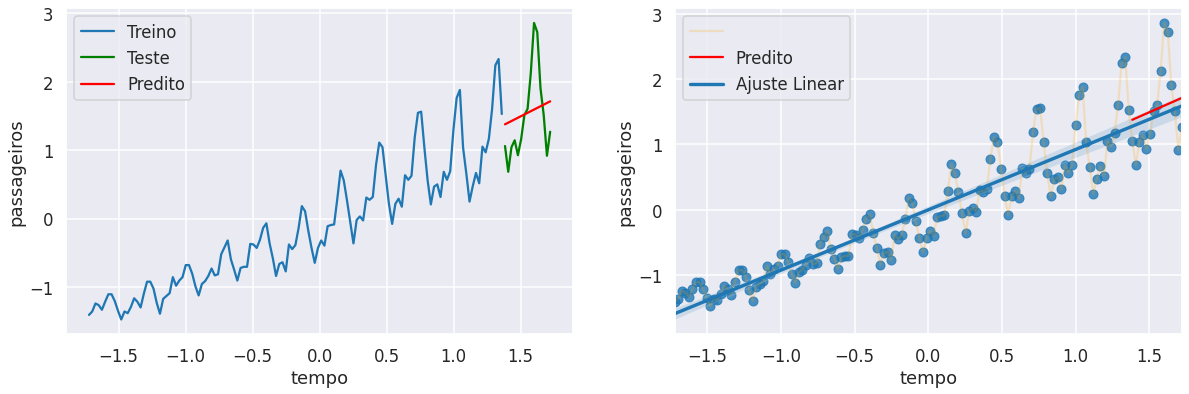

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax = sns.lineplot(x = x_treino, y = y_treino, label='Treino')
ax = sns.lineplot(x = x_teste, y = y_teste, label='Teste', color='green')
ax = sns.lineplot(x = x_teste, y = y_predito, label='Predito', color='red')

plt.subplot(1,2,2)
ax = sns.lineplot(x= viagens_normalizadas['tempo'], y = viagens_normalizadas['passageiros'], color='orange', label='linha', alpha=0.2)
ax = sns.lineplot(x = x_teste, y = y_predito, label='Predito',color='red')
ax = sns.regplot(x= viagens_normalizadas['tempo'], y = viagens_normalizadas['passageiros'])
ax.legend(['','Predito','Ajuste Linear'])

ax;

Note que no gráfico da esquerda que o valor predito em vermelho é basicamente uma reta que se ajusta aos dados. Podemos comparar com um plot de regressão do Seaborn como mostra o gráfico do lado direito.

Outro ponto importante de se dizer é que os dados em passageiros não esta na unidade real pois foi normalizado, para trazer esses dados para a escala real precisamos fazer o caminho inverso do "StandartScaler".

Antes de retornar aos dados reais, vou adicionar os dados em um único dataframe



In [ ]:
y_concat = pd.concat([y_treino, y_predito])

In [ ]:
viagens_normalizadas['passageiros_preditos'] = y_concat
viagens_normalizadas

,tempo,passageiros,passageiros_preditos
0,-1.720064,-1.407779,-1.407779
1,-1.696007,-1.357590,-1.357590
2,-1.671950,-1.240483,-1.240483
3,-1.647894,-1.265578,-1.265578
4,-1.623837,-1.332496,-1.332496
...,...,...,...
139,1.623837,2.724417,1.616905
140,1.647894,1.904669,1.640860
141,1.671950,1.511525,1.664814
142,1.696007,0.917627,1.688768


Agora temos ```x_treino/teste`` que é **tempo**, ``y_treino/teste`` que é a quantidade de passageiros e o número de passageiros predito, para transformar esses dados na escala verdadeira precisamos fazer a transformação inversa:

$$z = \frac{x - \mu}{\sigma} \longrightarrow x = z\sigma + \mu,$$

usando o Scikit learn temos:

In [ ]:
viagens_preditas = sc.inverse_transform(viagens_normalizadas[['tempo','passageiros_preditos']])

In [ ]:
viagens_preditas = pd.DataFrame(viagens_preditas, columns=['tempo','passageiros_preditos'])
viagens_preditas


,tempo,passageiros_preditos
0,1949.000000,112.000000
1,1949.083333,118.000000
2,1949.166667,132.000000
3,1949.250000,129.000000
4,1949.333333,121.000000
...,...,...
139,1960.583333,473.598094
140,1960.666667,476.461804
141,1960.750000,479.325486
142,1960.833333,482.189196


Perceba que na variável ``viagens`` temos as viagens reais e ``viagens_preditas`` temos as preditas pelo modelo. 

podemos compara-las:

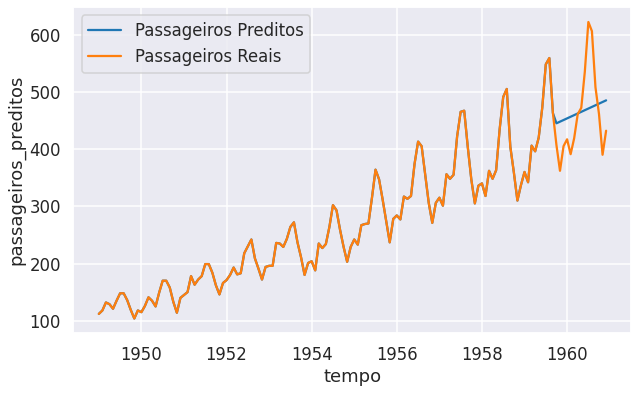

In [ ]:
ax = sns.lineplot(x = 'tempo', y='passageiros_preditos', data=viagens_preditas, label='Passageiros Preditos')
ax = sns.lineplot(x = 'tempo', y='passageiros', data=viagens, label='Passageiros Reais')

# Aprimorando o modelo

Ateriormente descrevemos o modelo como uma função que opera em um vetor para atingir um target. A modelagem deste problema foi descrita como:

$$y = a(Wx + b),$$

o ponto é quando aumentamos o número de camadas, cada uma das conexões, ou aresta do grafo, se torna a ativação na forma $y = a(Wx + b),$ isto é, se o neurônio (vértice do grafo) da camada escondida recebe três arestas a entrada que este neurônio recebe é a soma da aresta $y_1 + y_2 + y_3$. Abaixo temos uma estrutura de rede com mais de uma camada:

<img src='https://camo.githubusercontent.com/a59e2300b0d6a24052cd6185673c59df8bae8009f365dbef31be473e209d2fb9/68747470733a2f2f7777772e7265736561726368676174652e6e65742f70726f66696c652f4d6f68616d65645f5a616872616e362f7075626c69636174696f6e2f3330333837353036352f6669677572652f666967342f41533a33373131313835303736313031323340313436353439323935353536312f412d6879706f746865746963616c2d6578616d706c652d6f662d4d756c74696c617965722d50657263657074726f6e2d4e6574776f726b2e706e67' width=60%>



A rede que construimos só recebe um input (o ano/mes), no exemplo da imagem acima a rede recebe 4 inputs poderia ser aléém do ano/mes outras três informações, por exemplo, preço da moeda local em relação ao preço da do destino, quantidade de empregrados no país local, enfim, varias outras possíveis variáveis.





In [ ]:
regressor_multi_layer = Sequential()

Os argumentos de uma camada densa são: 

Arguments

*     units: Positive integer, dimensionality of the output space.
* activation: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
*     use_bias: Boolean, whether the layer uses a bias vector.
*     kernel_initializer: Initializer for the kernel weights matrix.
*     bias_initializer: Initializer for the bias vector.
*     kernel_regularizer: Regularizer function applied to the kernel weights matrix.
*     bias_regularizer: Regularizer function applied to the bias vector.
*     activity_regularizer: Regularizer function applied to the output of the layer (its "activation").
*     kernel_constraint: Constraint function applied to the kernel weights matrix.
*     bias_constraint: Constraint function applied to the bias vector.


In [ ]:
#  Definimos sempre um nó da rede, assim o primeiro parâmetro a ser passado
#  é quantas arestas saem deste nó.

regressor_multi_layer.add(
    Dense(
        8, input_dim=1,  # lembrando: 8 é o tamanho da camada seguinte.
        kernel_initializer='random_uniform',
        activation='linear',use_bias=False
    )
)

regressor_multi_layer.add(
    Dense(
        8, kernel_initializer='random_uniform',
        activation='linear', use_bias=False 
))

regressor_multi_layer.add(
    Dense(
        1, kernel_initializer='random_uniform',
        activation='linear', use_bias=False
    )
)

In [ ]:
regressor_multi_layer.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
regressor_multi_layer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor_multi_layer.fit(x_treino, y_treino, epochs=200)

Epoch 1/200
5/5 [==============================] - 0s 3ms/step - loss: 0.8945
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.8245
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.8429
Epoch 4/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8040
Epoch 5/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8017
Epoch 6/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7832
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 0.8876
Epoch 8/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8309
Epoch 9/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7842
Epoch 10/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7957
Epoch 11/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7693
Epoch 12/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8042
Epoch 13/200
5/5 [==============================] - 0s 2ms/st

In [ ]:
y_treino_mlp = regressor_multi_layer.predict(x_treino)
y_predito_mlp = regressor_multi_layer.predict(x_teste)

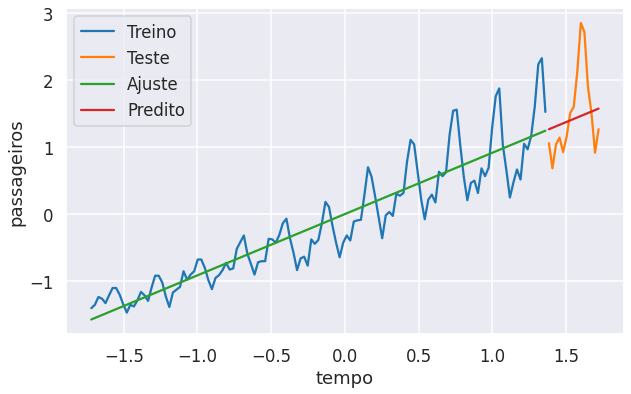

In [ ]:

ax = sns.lineplot(x = x_treino, y = y_treino, label='Treino')
ax = sns.lineplot(x = x_teste, y = y_teste, label='Teste')

ax = sns.lineplot(x = x_treino, y = y_treino_mlp[:,0], label='Ajuste')
ax = sns.lineplot(x = x_teste, y = y_predito_mlp[:,0], label='Predito')

ax;

> Perceba que é uma regressão linear. Mas o que aconteceu que o modelo apensar de mais camadas não fez nenhuma diferença?

Bom isso acontece porque as funções de ativação são puramente lineares, e portanto as respostas são combinações lineares o problema é que o nosso problema não é linear e portanto precisamos de combinações não lineares para soluciona-lo. 

Neurônios fisiológicos e outros sistemas biológicos por exemplo, tem uma função de ativação não linear. Note que esta função abaixo, a Heaviside ou qualquer delta de Dirac, não tem uma derivada no ponto 0

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Dirac_distribution_CDF.svg/800px-Dirac_distribution_CDF.svg.png' width=40%>

Isto implica que ao usarmos modelos matemáticos que envolvem diferenciação gerará um problema próximo desse ponto abrupto. Em muitos casos utiliza-se uma função contínua no lugar da Heabside, por exemplo a Sigmoide:


$f(z) = \frac{1}{1 + e^{-z}}$


<img src='https://upload.wikimedia.org/wikipedia/commons/a/ac/Logistic-curve.png' width=40%>

Note que $f$ é função de $z$, uma variável normalizada, não de $x$. 

Ao adicionar ativações não lineares em camadas escondidas podemos solucionar problemas internos de forma não linear. Vamos modificar a rede:


In [ ]:
regressor_multi_layer = Sequential()

#  Definimos sempre um nó da rede, assim o primeiro parâmetro a ser passado
#  é quantas arestas saem deste nó.

regressor_multi_layer.add(
    Dense(
        8, input_dim=1,  # lembrando: 8 é o tamanho da camada seguinte.
        kernel_initializer='random_uniform',
        activation='sigmoid',use_bias=False
    )
)

regressor_multi_layer.add(
    Dense(
        8, kernel_initializer='random_uniform',
        activation='sigmoid', use_bias=False 
))

regressor_multi_layer.add(
    Dense(
        1, kernel_initializer='random_uniform',
        activation='linear', use_bias=False
    )
)

Perceba que isso muda estruturalmente a rede neural:

In [ ]:

regressor_multi_layer.compile(loss='mean_squared_error', optimizer='adam')
regressor_multi_layer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


Vamos treinar o modelo novamente:

In [ ]:
regressor_multi_layer.fit(x_treino, y_treino, epochs=200)

Epoch 1/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7394
Epoch 2/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8314
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.7736
Epoch 4/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8059
Epoch 5/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7835
Epoch 6/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8038
Epoch 7/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7484
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 0.7893
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 0.8251
Epoch 10/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8683
Epoch 11/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8309
Epoch 12/200
5/5 [==============================] - 0s 2ms/step - loss: 0.8133
Epoch 13/200
5/5 [==============================] - 0s 2ms/st

Visualizando:

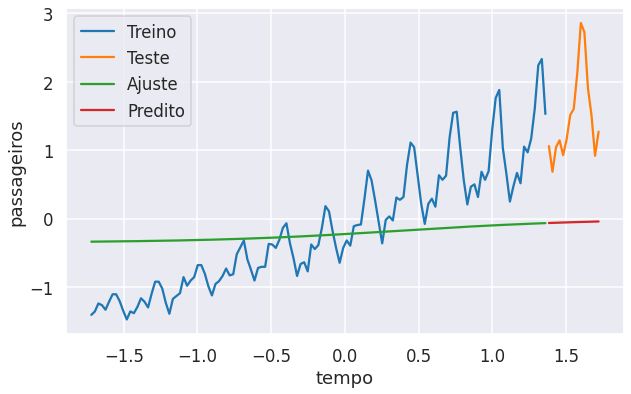

In [ ]:
y_treino_mlp = regressor_multi_layer.predict(x_treino)
y_predito_mlp = regressor_multi_layer.predict(x_teste)

ax = sns.lineplot(x = x_treino, y = y_treino, label='Treino')
ax = sns.lineplot(x = x_teste, y = y_teste, label='Teste')

ax = sns.lineplot(x = x_treino, y = y_treino_mlp[:,0], label='Ajuste')
ax = sns.lineplot(x = x_teste, y = y_predito_mlp[:,0], label='Predito')

ax;

Olha, o modelo agora nãão éé mais uma reta, se tornou levemente curvo.

# Analisando o problema de outra forma

Um ponto interessante é que estamos tratando de uma modelagem na forma $y = f(x)$, ou seja, temos uma variável dependente e uma independente, targets e features. Mas existe um problema de fundamento nessa abordagem, vejamos.

A variável dependente é o numero de passageiros e a independente é a data, mas note que apesar da data ter influencia na quantidade de passageiros em determinada época não é a data que causa isso, ela é apensa uma variável externa ao numero de passageiros, em econometria se essas variáveis independentes se chamam *exógenas*.

Podemos criar uma coluna temporaria que indica os meses e vamos ver quais as caracteristicas dos meses:

In [ ]:
meses = list(range(1,13)) * 12
viagens['mes'] = meses
viagens['ano'] = viagens['tempo'].astype(int)
viagens

,tempo,passageiros,mes,ano
0,1949.000000,112,1,1949
1,1949.083333,118,2,1949
2,1949.166667,132,3,1949
3,1949.250000,129,4,1949
4,1949.333333,121,5,1949
...,...,...,...,...
139,1960.583333,606,8,1960
140,1960.666667,508,9,1960
141,1960.750000,461,10,1960
142,1960.833333,390,11,1960


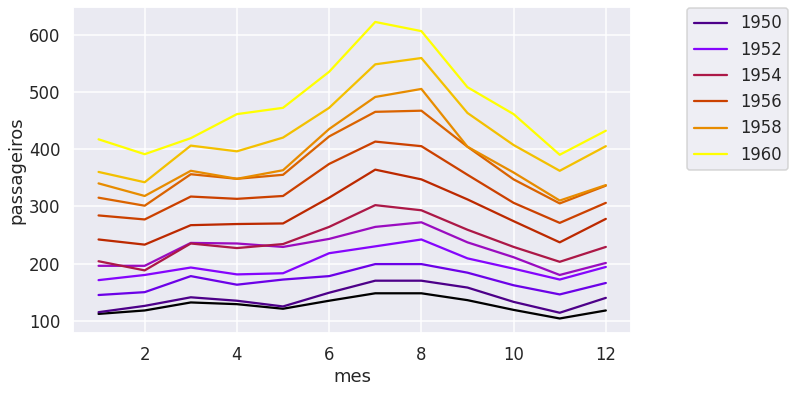

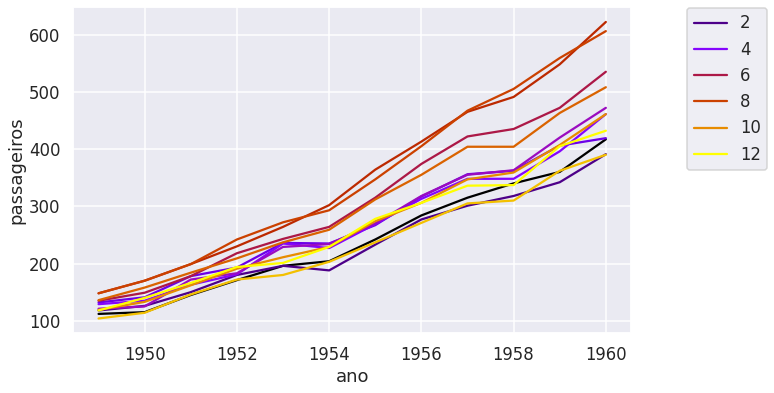

In [ ]:
plt.figure()
ax = sns.lineplot(x='mes', y='passageiros', hue='ano', data=viagens, palette='gnuplot')
ax.legend(loc=(1.1,0.5))
plt.show()

plt.figure()
ax = sns.lineplot(x='ano', y='passageiros', hue='mes', data=viagens, palette='gnuplot')
ax.legend(loc=(1.1,0.5))
plt.show()

Note que ao longo dos anos os numeros de cada mês parece estar aumentenado a cada ano, isso é ilustrado nos dois gráficos a cima, primeiro o número de passageiros no mês de cada ano e depois o número de passageriso no ano a cada mês, é nítido que aumenta.

A sacada então é se eu sei a quantidade de passageiros nos meses dos anos anteriores eu consigo estimar o número de passageiros este ano?

Para modelar isso é necessário um modelo recursivo, isto é, em vez de $y = f(x)$ precisamos de $y_{n+1} = f(y_n)$. Ou seja, dado o número de passageiros $y$ no mês em um ano $n$ consigo estimar o do ano $y_{n+1}$? 

Vamos criar uma defasagem, um atraso nos numeros de pasasgeiros, por exemplo:


|$$y_n$$|$$y_{n+1}$$|
---|---|
|112|118|
|118|132|
|132|129|
|129|121|
|...|...
e assim por diante

Vou criar uma função que irá gerar essa defasagem:

In [ ]:
def cria_defasagem(vetor, n_passo):
  """
  Dado o vetor, cria uma tabela com defasagem
  com passo n

  :param vetor: dados a sofrer defasagem
  :param n_passo: tamanho da defasagem
  :type vetor: Series
  :type n_passo: int

  :return: y_n e y_n+1
  :rtype: array
  """

  x_passado, y_futuro = [], []

  for i in range(n_passo, vetor.shape[0]):
    x_passado.append(list(vetor.iloc[i - n_passo : i]))
    y_futuro.append(vetor.iloc[i])

  x_passado, y_futuro = np.array(x_passado), np.array(y_futuro)

  return x_passado, y_futuro

feita a função vamos testa-la, lembrando que precisamos usar o y_treino e y_teste, nã podemos usar o x_treino/x_teste porque indicam os meses:

In [ ]:
x_treino_novo, y_treino_novo = cria_defasagem(y_treino, 1)

o resultado:

In [ ]:
print(10*'=', 'Dado de Treino', 10*'=')
print('y_n\n',x_treino_novo[:5])
print('y_n+1\n',y_treino_novo[:5])

========== Dado de Treino ==========
y_n
 [[-1.40777884]
 [-1.35759023]
 [-1.24048348]
 [-1.26557778]
 [-1.33249593]]
y_n+1
 [-1.35759023 -1.24048348 -1.26557778 -1.33249593 -1.21538918]


Feita a defasagem de 1 mes, vamos usar os dados do "presente" para tentar estimar mês "futuro" mas com base apenas no número de passageiros não com base no mês em si.


In [ ]:
x_teste_novo, y_teste_novo = cria_defasagem(y_teste, 1)

In [ ]:
print(10*'=', 'Dado de Teste', 10*'=')
print('y_n\n',x_teste_novo[:5])
print('y_n+1\n',y_teste_novo[:5])

========== Dado de Teste ==========
y_n
 [[1.05982773]
 [0.68341317]
 [1.04309819]
 [1.14347541]
 [0.92599144]]
y_n+1
 [0.68341317 1.04309819 1.14347541 0.92599144 1.16020494]


## Instanciando modelo

Aqui vamos instanciar um novo modelo que será um modelo que recebe dados recursivos como já foi dito anterioremente, isto é, $y_{n+1} = f(y_n)$:

In [ ]:
regressor_recursivo = Sequential()

#  Definimos sempre um nó da rede, assim o primeiro parâmetro a ser passado
#  é quantas arestas saem deste nó.

regressor_recursivo.add(
    Dense(
        8, input_dim=1,  # lembrando: 8 é o tamanho da camada seguinte.
        kernel_initializer='random_uniform',
        activation='linear',use_bias=False
    )
)

regressor_recursivo.add(
    Dense(
        64, kernel_initializer='random_uniform',
        activation='sigmoid', use_bias=False 
))

regressor_recursivo.add(
    Dense(
        1, kernel_initializer='random_uniform',
        activation='linear', use_bias=False
    )
)

In [ ]:
regressor_recursivo.compile(loss='mean_squared_error', optimizer='adam')
regressor_recursivo.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 64        
Total params: 584
Trainable params: 584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regressor_recursivo.fit(x_treino_novo,y_treino_novo, epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 0.7604
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7410
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7762
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7691
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.8678
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7190
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7965
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7420
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7171
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 0.8230
Epoch 11/100
4/4 [==============================] - 0s 2ms/step - loss: 0.8894
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 0.7565
Epoch 13/100
4/4 [==============================] - 0s 3ms/st

Realizando a predição

In [ ]:
y_predito_recursivo_treino = regressor_recursivo.predict(x_treino_novo)
y_predito_recursivo = regressor_recursivo.predict(x_teste_novo)

Note que o fato de criar uma defasagem de 1 mês, temos um dado a menos:

In [ ]:
x_treino_novo.shape, y_treino_novo.shape, x_teste_novo.shape, y_teste_novo.shape, y_predito_recursivo_treino.shape, y_predito_recursivo.shape

((128, 1), (128,), (14, 1), (14,), (128, 1), (14, 1))

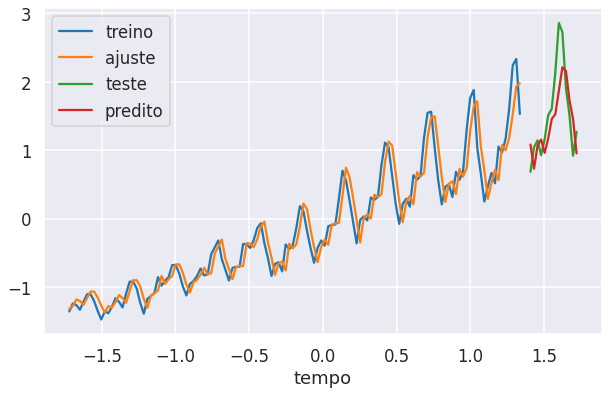

In [ ]:
# Treino
ax = sns.lineplot( x = 'tempo', y = y_treino_novo,
                  data=viagens_normalizadas.iloc[:y_treino_novo.shape[0]],
                  label='treino')

ax = sns.lineplot( x = 'tempo', y = y_predito_recursivo_treino[:,0],
                  data=viagens_normalizadas.iloc[:y_predito_recursivo_treino.shape[0]],
                  label='ajuste')


# Teste
ax = sns.lineplot( x = 'tempo', y = y_teste_novo,
                  data=viagens_normalizadas.iloc[-y_teste_novo.shape[0]:],
                  label='teste')

# Predito 
ax = sns.lineplot( x = 'tempo', y = y_predito_recursivo[:,0],
                  data=viagens_normalizadas.iloc[-y_predito_recursivo.shape[0]:],
                  label='predito')

ax;

## Modificando a janela

No código onde criamos a defasagem temos a variável ``n_passo``, veja:

```python
def cria_defasagem(vetor, n_passo):
  x_passado, y_futuro = [], []

  for i in range(n_passo, vetor.shape[0]):
    x_passado.append(list(vetor.iloc[i - n_passo : i]))
    y_futuro.append(vetor.iloc[i])

  x_passado, y_futuro = np.array(x_passado), np.array(y_futuro)

  return x_passado, y_futuro
```

Perceba a linha de código que indica ``vetor.iloc[i - n_passo : i]`` isso aqui gera uma janela de dados $y_n$ para prever $y_{n+1}$. Vejamos o que acontece quando aumentamos o número da janela:

In [ ]:
x_treino_novo, y_treino_novo = cria_defasagem(y_treino, 4)

print(10*'=', 'Dado de Treino', 10*'=')
print('y_n\n',x_treino_novo[:5])
print('y_n+1\n',y_treino_novo[:5])

========== Dado de Treino ==========
y_n
 [[-1.40777884 -1.35759023 -1.24048348 -1.26557778]
 [-1.35759023 -1.24048348 -1.26557778 -1.33249593]
 [-1.24048348 -1.26557778 -1.33249593 -1.21538918]
 [-1.26557778 -1.33249593 -1.21538918 -1.10664719]
 [-1.33249593 -1.21538918 -1.10664719 -1.10664719]]
y_n+1
 [-1.33249593 -1.21538918 -1.10664719 -1.10664719 -1.20702441]


note que agora, cada elemento do $y_n$ do vetor tem 4 componentes, isso significa que estamos usando 
$$\vec{v} = [-1.40777884, -1.35759023, -1.24048348, -1.26557778],$$ 
para estimar o valor de $y_{n+1}$, que no caso é $-1.33249593$

Vamos fazer o mesmo com os dados de teste:

In [ ]:
x_teste_novo, y_teste_novo = cria_defasagem(y_teste, 4)

print(10*'=', 'Dado de Treino', 10*'=')
print('y_n\n',x_teste_novo[:5])
print('y_n+1\n',y_teste_novo[:5])

========== Dado de Treino ==========
y_n
 [[1.05982773 0.68341317 1.04309819 1.14347541]
 [0.68341317 1.04309819 1.14347541 0.92599144]
 [1.04309819 1.14347541 0.92599144 1.16020494]
 [1.14347541 0.92599144 1.16020494 1.5115252 ]
 [0.92599144 1.16020494 1.5115252  1.60353765]]
y_n+1
 [0.92599144 1.16020494 1.5115252  1.60353765 2.13051803]


### Treinando o modelo novamente:

Como agora o imput tem dimensão $(4,)$ precisamos mudar o ``input_dim`` do modelo:

In [ ]:
regressor_recursivo_janela4 = Sequential()

#  Definimos sempre um nó da rede, assim o primeiro parâmetro a ser passado
#  é quantas arestas saem deste nó.

regressor_recursivo_janela4.add(
    Dense(
        8, input_dim=4,  # lembrando: 8 é o tamanho da camada seguinte.
        kernel_initializer='random_uniform',
        activation='linear',use_bias=False
    )
)

regressor_recursivo_janela4.add(
    Dense(
        64, kernel_initializer='random_uniform',
        activation='sigmoid', use_bias=False 
))

regressor_recursivo_janela4.add(
    Dense(
        1, kernel_initializer='random_uniform',
        activation='linear', use_bias=False
    )
)

regressor_recursivo_janela4.compile(loss='mean_squared_error',optimizer='adam')
regressor_recursivo_janela4.fit(x_treino_novo, y_treino_novo, epochs=300)

Epoch 1/300
4/4 [==============================] - 0s 2ms/step - loss: 0.7501
Epoch 2/300
4/4 [==============================] - 0s 3ms/step - loss: 0.8190
Epoch 3/300
4/4 [==============================] - 0s 4ms/step - loss: 0.8368
Epoch 4/300
4/4 [==============================] - 0s 4ms/step - loss: 0.7705
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 0.7993
Epoch 6/300
4/4 [==============================] - 0s 4ms/step - loss: 0.7642
Epoch 7/300
4/4 [==============================] - 0s 3ms/step - loss: 0.7499
Epoch 8/300
4/4 [==============================] - 0s 3ms/step - loss: 0.7908
Epoch 9/300
4/4 [==============================] - 0s 4ms/step - loss: 0.6844
Epoch 10/300
4/4 [==============================] - 0s 2ms/step - loss: 0.6375
Epoch 11/300
4/4 [==============================] - 0s 3ms/step - loss: 0.7272
Epoch 12/300
4/4 [==============================] - 0s 2ms/step - loss: 0.6686
Epoch 13/300
4/4 [==============================] - 0s 2ms/st

### Estimando

In [ ]:
y_predito_recursivo_treino = regressor_recursivo_janela4.predict(x_treino_novo)
y_predito_recursivo = regressor_recursivo_janela4.predict(x_teste_novo)

### Exibindo os dados:

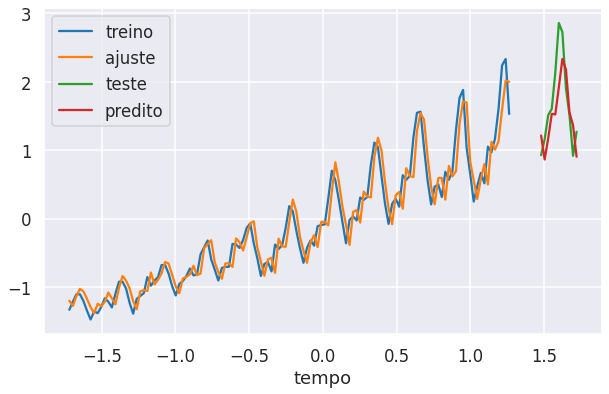

In [ ]:
# Treino
ax = sns.lineplot( x = 'tempo', y = y_treino_novo,
                  data=viagens_normalizadas.iloc[:y_treino_novo.shape[0]],
                  label='treino')

ax = sns.lineplot( x = 'tempo', y = y_predito_recursivo_treino[:,0],
                  data=viagens_normalizadas.iloc[:y_predito_recursivo_treino.shape[0]],
                  label='ajuste')


# Teste
ax = sns.lineplot( x = 'tempo', y = y_teste_novo,
                  data=viagens_normalizadas.iloc[-y_teste_novo.shape[0]:],
                  label='teste')

# Predito 
ax = sns.lineplot( x = 'tempo', y = y_predito_recursivo[:,0],
                  data=viagens_normalizadas.iloc[-y_predito_recursivo.shape[0]:],
                  label='predito')

ax;

# Outro problema

Agora vamos analisar um problema de bicicletas 

In [ ]:
url_bicicletas = 'https://gist.githubusercontent.com/ConradBitt/44806a81d5aa6d36596db9cd61f54b44/raw/d68946d32205d0325cd8498424ffb70c520c6047/bicicletas.csv'

bicicletas = pd.read_csv(url_bicicletas)

## Estatisticas Descritivas

In [ ]:
display(bicicletas.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datas        17414 non-null  object 
 1   contagem     17414 non-null  int64  
 2   temperatura  17414 non-null  float64
 3   sensacao     17414 non-null  float64
 4   umidade      17414 non-null  float64
 5   vel_vento    17414 non-null  float64
 6   clima        17414 non-null  float64
 7   feriado      17414 non-null  float64
 8   final_ds     17414 non-null  float64
 9   estacao      17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


None

In [ ]:
bikes = bicicletas[['datas','contagem']]
bikes['datas'] = pd.to_datetime(bikes['datas'])
bikes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datas     17414 non-null  datetime64[ns]
 1   contagem  17414 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 272.2 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Normalizando dados

In [ ]:
normalizador = StandardScaler()

In [ ]:
normalizador.fit(bikes['contagem'].values.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
contagem_bikes_normalizada = normalizador.fit_transform(bikes['contagem'].values.reshape(-1,1))

In [ ]:
bikes['contagem_normalizada'] = contagem_bikes_normalizada

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
bikes.head()

,datas,contagem,contagem_normalizada
0,2015-01-04 00:00:00,182,-0.885745
1,2015-01-04 01:00:00,138,-0.926295
2,2015-01-04 02:00:00,134,-0.929982
3,2015-01-04 03:00:00,72,-0.987120
4,2015-01-04 04:00:00,47,-1.010160


## Separando dados de treino e teste

In [ ]:
tamanho_treino = int(len(bikes) * 0.9)
tamanho_teste = int(len(bikes) * 0.1)

print(f'Quantidade treino: {tamanho_treino}')
print(f'Quantidade teste: {tamanho_teste}')

Quantidade treino: 15672
Quantidade teste: 1741


In [ ]:
dados_treino = bikes.iloc[:tamanho_treino,:]
dados_teste = bikes.iloc[-tamanho_teste:,:]

In [ ]:
dados_treino.shape, dados_teste.shape

((15672, 3), (1741, 3))

In [ ]:
bikes.describe().T

,count,mean,std,min,25%,50%,75%,max
contagem,17414.0,1.143102e+03,1085.108068,0.000000,257.000000,844.00000,1671.750000,7860.000000
contagem_normalizada,17414.0,4.472387e-17,1.000029,-1.053475,-0.816626,-0.27565,0.487199,6.190251


## Exibindo os dados:

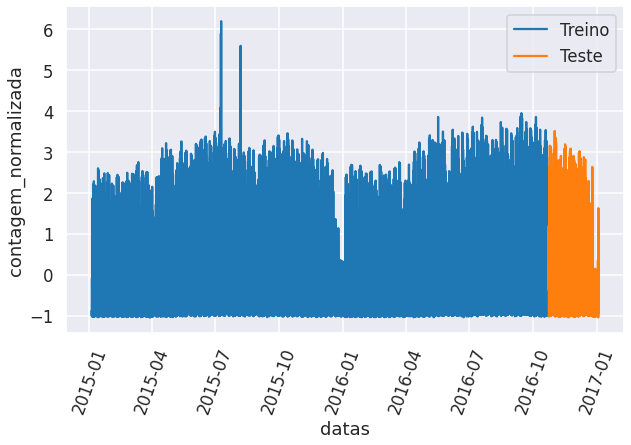

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x='datas',y='contagem_normalizada', data=dados_treino, label='Treino')
ax = sns.lineplot(x='datas',y='contagem_normalizada', data=dados_teste, label='Teste')
plt.xticks(rotation=70)
ax;


## Criando janelas nos dados de treino e teste

In [ ]:
x_treino, y_treino = cria_defasagem(dados_treino['contagem_normalizada'],10)

In [ ]:
x_teste, y_teste = cria_defasagem(dados_teste['contagem_normalizada'],10)

vamos analisar a dimensão dos dados para criar a rede:

In [ ]:
x_treino.shape, y_treino.shape, x_teste.shape, y_teste.shape,

((15662, 10), (15662,), (1731, 10), (1731,))

note que a dimensão dos dados de entrada é $(1,10)$ ou seja, a rede precisa ter entrada de dimensão 10.

## Criando um modelo: Redes Recorrentes 

> Fonte: https://keras.io/guides/working_with_rnns/

Até aqui utilizamos uma rede de perceptrons, que geralmente tem a seguinte estrutura:

<img src='https://miro.medium.com/max/4523/1*-IPQlOd46dlsutIbUq1Zcw.png' width=60%>

Porém, esta estrutura não consegue analisar tão bem o caráter sequencial de séries temporais, isto é, não é tão sensível em problemas cujo resultado $y_{t+1}$ esta correlacionado com o valor de $y_t$. A correlação em séries temporais é como se fosse uma memoria que o problema tem intrinsecamente.

Uma arquitetura de rede muito boa para lidar com este tipo de problema são as chamadas redes recorrentes. A estrutura das redes neurais recorrentes é um pouco diferente das MLP (Mult Layer Perceptron), veja:

<img src='https://raw.githubusercontent.com/ConradBitt/processamento_linguagem_natural/master/MLP_RNN.png' width=60%>

Note que as redes recorrentes tem um mecanismo de reavaliar as informações dentro da propria rede, fazendo assim com que crie-se uma estrutura sequencial na ordem dos dados.

O surgimento de redes recorrentes deve-se diretamente da análise da linguagem e problemas de NLP (Natural Language Processing ou Linguagem de Processamento Natural), pois ao analisar uma entrada do tipo "*TENHO + FORME* " é esperado que as possíveis respostas são algo do parecido com " *COMER + PIZZA* " ou " *HORA + ALMOÇO* ", perceba, a estutura passada define uma possível estrutura no futuro. São esses problemas que RNN solucionam.



### Redimensionando dados

Tendo em vista que as RNN realizam operações de recorrencia, não podemos dar um vetor de entrada na forma $(1,n)$, é preciso fornecer a entrada na forma $(n,1)$. Dado que nossos vetores de entrada são da forma $(1,10)$ é preciso redimensiona-los:

In [ ]:
print(f'x_treino antes: \n {x_treino[:2]}')

x_treino = x_treino.reshape((x_treino.shape[0],x_treino.shape[1], 1))

print(f'x_treino depois: \n {x_treino[:2]}')


x_treino antes: 
 [[-0.88574518 -0.9262953  -0.92998167 -0.98712048 -1.01016032 -1.01108192
  -1.00647395 -0.9843557  -0.93274645 -0.77607553]
 [-0.9262953  -0.92998167 -0.98712048 -1.01016032 -1.01108192 -1.00647395
  -0.9843557  -0.93274645 -0.77607553 -0.56687377]]
x_treino depois: 
 [[[-0.88574518]
  [-0.9262953 ]
  [-0.92998167]
  [-0.98712048]
  [-1.01016032]
  [-1.01108192]
  [-1.00647395]
  [-0.9843557 ]
  [-0.93274645]
  [-0.77607553]]

 [[-0.9262953 ]
  [-0.92998167]
  [-0.98712048]
  [-1.01016032]
  [-1.01108192]
  [-1.00647395]
  [-0.9843557 ]
  [-0.93274645]
  [-0.77607553]
  [-0.56687377]]]


Vamos fazer o mesmo com os dados de teste:

In [ ]:
print(f'x_treino antes: \n {x_teste[:2]}')

x_teste = x_teste.reshape((x_teste.shape[0],x_teste.shape[1], 1))

print(f'x_treino depois: \n {x_teste[:2]}')

x_treino antes: 
 [[-0.36780954  0.19897056  0.69755273  0.94269664  1.19060533  0.9767956
   1.16387912  0.85330205  0.6293548   0.21463765]
 [ 0.19897056  0.69755273  0.94269664  1.19060533  0.9767956   1.16387912
   0.85330205  0.6293548   0.21463765 -0.22957049]]
x_treino depois: 
 [[[-0.36780954]
  [ 0.19897056]
  [ 0.69755273]
  [ 0.94269664]
  [ 1.19060533]
  [ 0.9767956 ]
  [ 1.16387912]
  [ 0.85330205]
  [ 0.6293548 ]
  [ 0.21463765]]

 [[ 0.19897056]
  [ 0.69755273]
  [ 0.94269664]
  [ 1.19060533]
  [ 0.9767956 ]
  [ 1.16387912]
  [ 0.85330205]
  [ 0.6293548 ]
  [ 0.21463765]
  [-0.22957049]]]


## Instanciando a rede

As RNN também são estruturadas de forma Sequencial, e portanto criamos um objeto do tipo ``Sequential()``, caso precise consultar as informações sobre esta estrutura:

> https://keras.io/api/models/sequential/

In [ ]:
rnn = Sequential()

### LSTM

> fonte: https://keras.io/api/layers/recurrent_layers/lstm/

Entretanto, diferente das redes MLP as RNN não tem perceptrons, elas tem outras formas de ponderar as informações internas. O algorítmo que vou utilizar se chama LSTM, ou *Long Short-Term Memory layer [(Hochreiter 1997)](https://www.bioinf.jku.at/publications/older/2604.pdf)*.

LSTM vem de "*Long Short Term Memory*", isto é, um pequeno termo de memória de longo prazo, esta técnica é excelente para séries temporais muito longas, nelas o LSTM tem uma sensibilidade maior as informações como um todo da série.

<img src='https://raw.githubusercontent.com/ConradBitt/processamento_linguagem_natural/master/RNN.png' width=60%>

Outro ponto importante em redes recorrentes é a atualização dos pesos de cara neurônio. O fato de poder ter muitas camadas escondidas e muitos *loopings* em cada camada, conforme os pesos são atualizados o caracter sequencial faz com que cada vez menos os pesos sejam corrigidos. Isso é um problema, porque a estrutura de uma rede neural consiste na otimização através do gradiente, esta caracteristica do gradiente perder a capacidade de atualização recebe o nome de *gradient vanishing* (gradiente desaparecendo ou desaparecimento do gradiente).

Uma forma de contornar o problema do gradient vanishing é utilizar uma certa distribuição inicial de pesos em cada neurônio. Esta distribuição é chamada de Glorot Uniform

<img src='https://raw.githubusercontent.com/ConradBitt/processamento_linguagem_natural/master/RNN_Glorot_uniform.png' width=60%>

No keras, por padrão a distribuição atribuida aos pesos já é a glorot uniform.

Outro ponto que diferente as RNN da MLP, além do **looping** na estrutura são os neurônios. Diferente das MLP que tem uma combinação linear de funções de ativação não lineares, as RNN com LSTM tem uma estrutura um pouco diferente onde um único neuronio tem 3 camadas internas.


Note que dentro de um único neurônio $A$ tem uma outra rede com três camadas. Essas camadas tem produtos representados por $X$ e somas representadas por $+$ além da ativação $tanh$ (tangente hiperbólica).


<img src='https://raw.githubusercontent.com/ConradBitt/processamento_linguagem_natural/master/RNN_Neuronio.png' width=70%>

1. Entrada recebe a aplicação de $\sigma$.

2. Soma a entrada com a aplicação de $\sigma$ à saida da ativação $tanh$ aplicada à entrada.

3. Aplica a ativação $\sigma$ à entrada e depois uma ativação $tanh$


No keras os parâmetros padrões do método LSTM, são: 

The requirements to use the cuDNN implementation are

    activation == tanh
    recurrent_activation == sigmoid
    recurrent_dropout == 0
    unroll is False
    use_bias is True
    Inputs, if use masking, are strictly right-padded.
    Eager execution is enabled in the outermost context.



In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
# camada de recorrencia
rnn.add(
    LSTM(
        128,  # steps recurssivos
        input_shape = (  # dimensão da entrada, lembrando: (10, 1)
            x_treino.shape[1], 
            x_treino.shape[2]
        )
    )
)

# camada de saída

rnn.add(
    Dense(
        units=1
    )
)

Lembrando que sempre devemos compilar a rede. Ao compilar a rede devemos falar a forma de medir o erro dela que no caso vamos continuar usando o mínimos dos quadrados e um otimizador. Desta vez o otimizador sera o **RMSProp**. A descrição do otimizador é:

>The gist of RMSprop is to:
* Maintain a moving (discounted) average of the square of gradients
* Divide the gradient by the root of this average
* This implementation of RMSprop uses plain momentum, not Nesterov momentum.

ou seja, basicamente ele analisa a dispersão da média dos gradientes. Para mais informações consultar:


> https://keras.io/api/optimizers/rmsprop/


In [ ]:
rnn.compile(loss='mean_squared_error', optimizer='RMSProp')

Assim como na MLP podemos analisar uma descrição da organização da rede:

In [ ]:
rnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


Note podemos ver que o total de parâmetros internos desta rede é de 66689, isto é, o modelo irá ajustar 66689 parâmetros. Vamos ajustar o modelo:

In [ ]:
resultado = rnn.fit(
    x_treino, y_treino,
    validation_data = (
        x_teste, y_teste
    ),
    epochs = 50
)

Epoch 1/50
490/490 [==============================] - 8s 13ms/step - loss: 0.4853 - val_loss: 0.0781
Epoch 2/50
490/490 [==============================] - 6s 11ms/step - loss: 0.0880 - val_loss: 0.0855
Epoch 3/50
490/490 [==============================] - 6s 12ms/step - loss: 0.0642 - val_loss: 0.0374
Epoch 4/50
490/490 [==============================] - 6s 11ms/step - loss: 0.0454 - val_loss: 0.0255
Epoch 5/50
490/490 [==============================] - 6s 11ms/step - loss: 0.0434 - val_loss: 0.0266
Epoch 6/50
490/490 [==============================] - 5s 11ms/step - loss: 0.0375 - val_loss: 0.0442
Epoch 7/50
490/490 [==============================] - 6s 11ms/step - loss: 0.0374 - val_loss: 0.0233
Epoch 8/50
490/490 [==============================] - 6s 11ms/step - loss: 0.0367 - val_loss: 0.0225
Epoch 9/50
490/490 [==============================] - 6s 11ms/step - loss: 0.0342 - val_loss: 0.0239
Epoch 10/50
490/490 [==============================] - 5s 11ms/step - loss: 0.0318 - val_lo

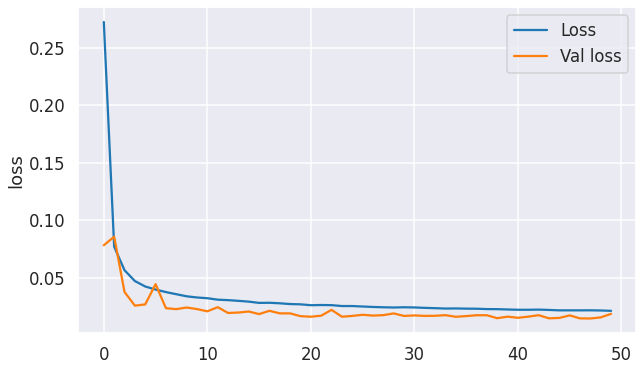

In [ ]:
historico_loss = pd.DataFrame(resultado.history)


ax = sns.lineplot(x = historico_loss.index, y='loss', data=historico_loss, label='Loss')
ax = sns.lineplot(x = historico_loss.index, y='val_loss', data=historico_loss, label='Val loss')
ax;

In [ ]:
# ajuste
y_ajustado = rnn.predict(x_treino)

In [ ]:
print(len(y_ajustado))
print(len(y_treino))

15662
15662


In [ ]:
print(y_treino.shape)
print(y_ajustado.shape)

(15662,)
(15662, 1)


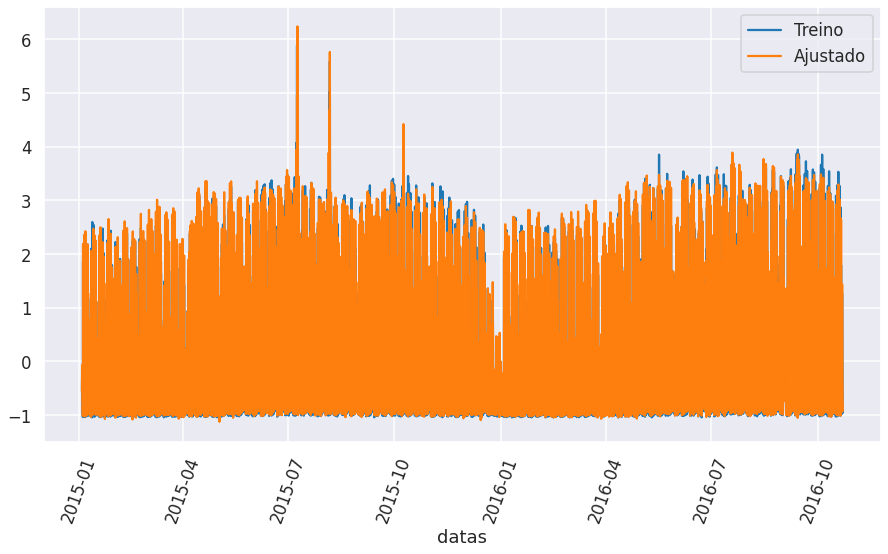

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='datas', y=y_treino, data=bikes.iloc[:len(y_treino),:], label='Treino')
ax = sns.lineplot(x='datas', y=y_ajustado[:,0], data=bikes.iloc[:len(y_ajustado),:], label='Ajustado')
plt.xticks(rotation=70)

ax;

In [ ]:
y_predito = rnn.predict(x_teste)

In [ ]:
print(y_teste.shape)
print(y_predito.shape)

(1731,)
(1731, 1)


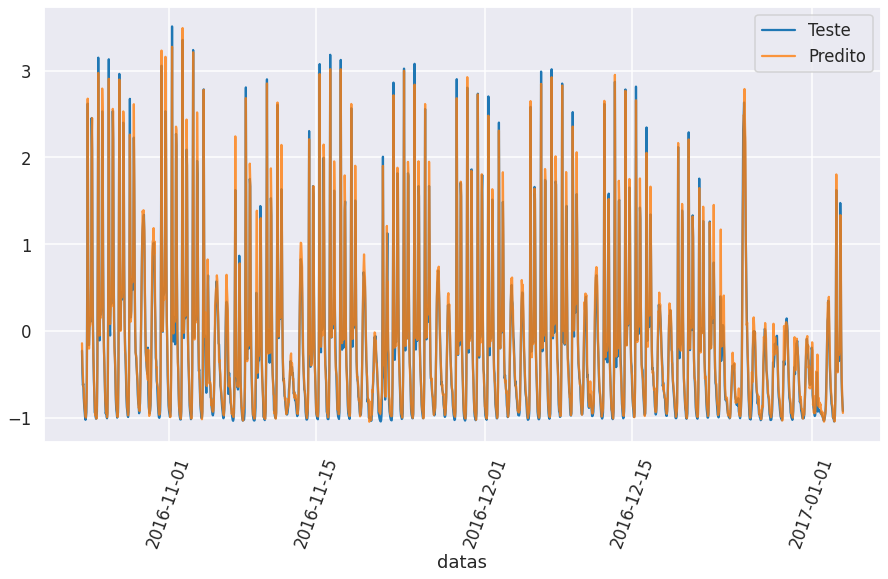

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='datas', y=y_teste, data=bikes.iloc[-len(y_teste):,:], label='Teste')
ax = sns.lineplot(x='datas', y=y_predito[:,0], data=bikes.iloc[-len(y_teste):,:], label='Predito', alpha=0.8)
plt.xticks(rotation=70)

ax;

Note que a predição do modelo esta muito boa.

## Usando GRU 

Além da LSTM e varias outras estruturas, o keras tem implementada a GRU ou em Unidade Recorrente Fechada. Diferente da LSTM a GRU tem menos camadas dentro de cada neurônio, isso faz com que o treinamento e otimização da rede seja mais rápido justamente porque tem menos parâmetros para ajustar.

<img src='https://raw.githubusercontent.com/ConradBitt/processamento_linguagem_natural/master/RNN_Neuronios.png' width=80%>

> **Vale ressaltar que apesar das GRU serem mais rápidas, as LSTM conseguem "lembrar mais" das séries temporais maiores.**


In [ ]:
from tensorflow.keras.layers import GRU 

In [ ]:
rnn_gru = Sequential()

In [ ]:
rnn_gru.add(
    GRU(
        128,
        input_shape = (
            x_treino.shape[1],
            x_treino.shape[2]
        )
    )
)

rnn_gru.add(
    Dense(
        units=1
    )
)

In [ ]:
rnn_gru.compile(
    loss = 'mean_squared_error',
    optimizer = 'RMSProp'
)

### Vamos comprar as redes:

In [ ]:
display(rnn.summary())
display(rnn_gru.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


None

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               50304     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


None

Note que o total de parâmetros na rede com LSTM é de $66689$ já na rede com GRU tem $50433$, quase 16mil parâmetros a menos para ajustar.

In [ ]:
resultado_gru = rnn_gru.fit(
    x_treino, 
    y_treino,
    validation_data = (
        x_teste,
        y_teste
    ),
    epochs=50
)

Epoch 1/50
490/490 [==============================] - 7s 11ms/step - loss: 0.3508 - val_loss: 0.0523
Epoch 2/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0687 - val_loss: 0.0339
Epoch 3/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0444 - val_loss: 0.0257
Epoch 4/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0411 - val_loss: 0.0301
Epoch 5/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0375 - val_loss: 0.0375
Epoch 6/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0408 - val_loss: 0.0322
Epoch 7/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0348 - val_loss: 0.0283
Epoch 8/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0335 - val_loss: 0.0217
Epoch 9/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0323 - val_loss: 0.0185
Epoch 10/50
490/490 [==============================] - 5s 10ms/step - loss: 0.0302 - val_lo

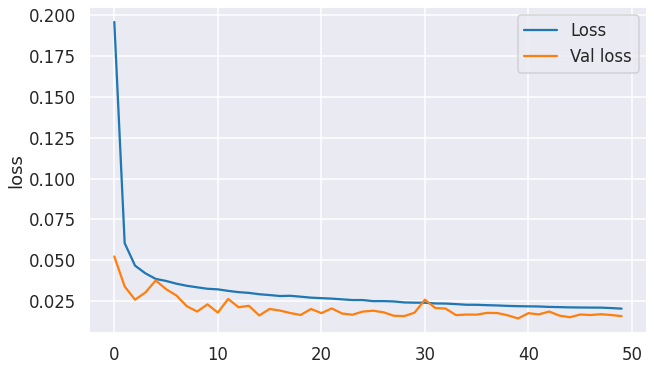

In [ ]:
historico_loss_gru = pd.DataFrame(resultado_gru.history)


ax = sns.lineplot(x = historico_loss_gru.index, y='loss', data=historico_loss_gru, label='Loss')
ax = sns.lineplot(x = historico_loss_gru.index, y='val_loss', data=historico_loss_gru, label='Val loss')
ax;



### Visualizando o ajuste pelo GRU

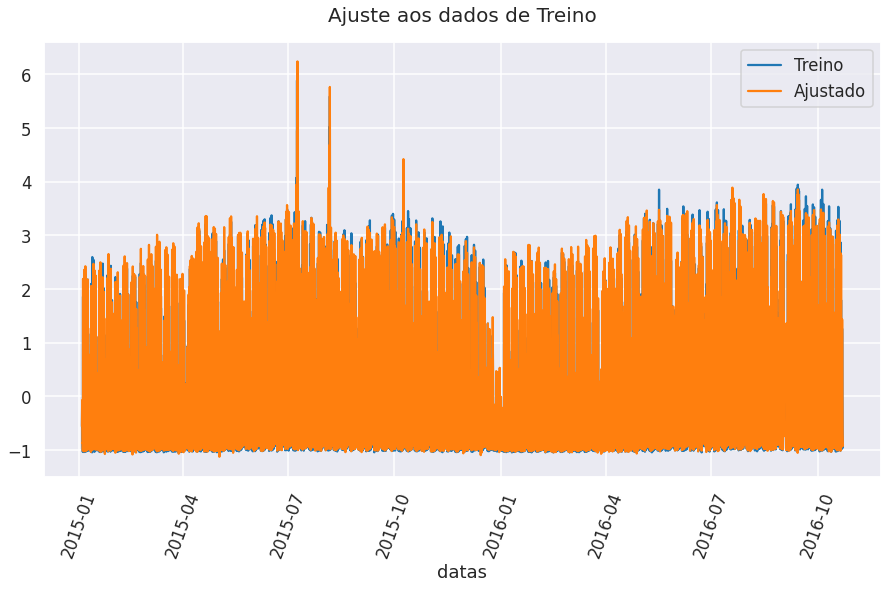

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='datas', y=y_treino, data=bikes.iloc[:len(y_treino),:], label='Treino')
ax = sns.lineplot(x='datas', y=y_ajustado[:,0], data=bikes.iloc[:len(y_ajustado),:], label='Ajustado')
plt.xticks(rotation=70)
plt.title('Ajuste aos dados de Treino', fontsize=20, pad = 20)
ax;

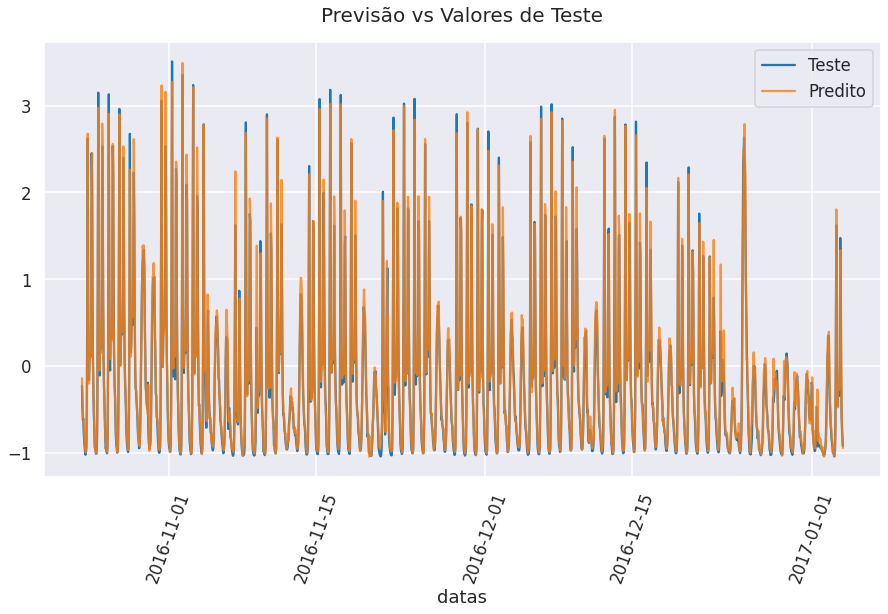

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='datas', y=y_teste, data=bikes.iloc[-len(y_teste):,:], label='Teste')
ax = sns.lineplot(x='datas', y=y_predito[:,0], data=bikes.iloc[-len(y_teste):,:], label='Predito', alpha=0.8)
plt.xticks(rotation=70)
plt.title('Previsão vs Valores de Teste', fontsize=20, pad = 20)
ax;

## Mas qual é melhor: LSTM ou GRU?

Lembrando que temos os resultados em função da Loss (Mean Squared Error) aplicada aos dados de teste e o Val Loss que é a mesma metrica aplicada aos dados de teste.

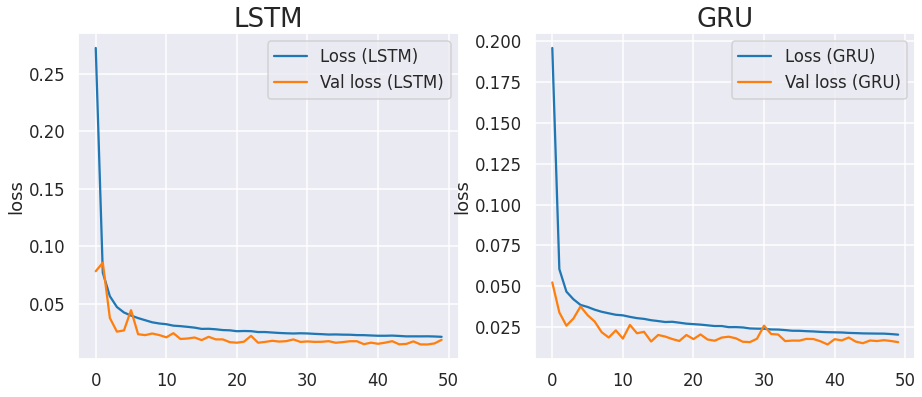

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.lineplot(x = historico_loss.index, y='loss', data=historico_loss, label='Loss (LSTM)')
sns.lineplot(x = historico_loss.index, y='val_loss', data=historico_loss, label='Val loss (LSTM)')
plt.title('LSTM', fontsize=26)

plt.subplot(1,2,2)
sns.lineplot(x = historico_loss_gru.index, y='loss', data=historico_loss_gru, label='Loss (GRU)')
sns.lineplot(x = historico_loss_gru.index, y='val_loss', data=historico_loss_gru, label='Val loss (GRU)')
plt.title('GRU', fontsize=26)

ax;



Note que em nenhum momento as redes recorrentes baseadas em LSTM ou GRU divergiram para uma situação de overfitting, na maior parte dos casos a métrica de avaliação nos dados de treino sempre ficou um pouco maior do que nos dados de teste.